In [1]:
!pip install h5py pygrappa

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pygrappa import grappa   # Install using `pip install pygrappa`

def generate_kspace_mask(resolution, num_centeral_lines=32, grappa_factor=3):
    mask = np.zeros(resolution, dtype=bool)
    center = resolution[0] // 2
    mask[center - num_centeral_lines // 2:center + num_centeral_lines // 2, :] = True
    mask[::grappa_factor] = True
    return mask

def get_autocalib(kspace, resolution, num_centeral_lines=32):
    center = resolution[0] // 2
    return kspace[:, center-num_centeral_lines//2:center+num_centeral_lines//2].copy()
    
def rss(images):
    return np.linalg.norm(images, axis=0)
    
def recon_ifft(undersampled_kspace):
    return np.fft.ifftshift(
        np.fft.ifft2(
            np.fft.fftshift(
                undersampled_kspace,
                axes=(1, 2)
            ),
            axes=(1, 2)),
        axes=(1, 2)
    )    

# You can play with this!
NUM_ACS_LINES = 32
AF = 3

In [2]:
data = np.load("raw_data.npy", allow_pickle=True).item()
kspace, image = data["kspace"], data["image"]

(-0.5, 319.5, 319.5, -0.5)

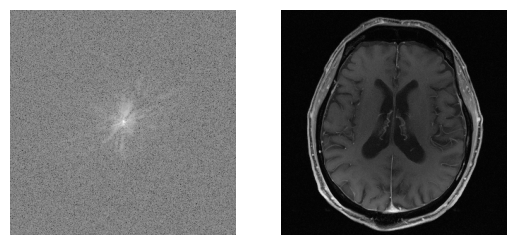

In [3]:
plt.subplot(1, 2, 1)
plt.imshow(np.log(np.abs(kspace[0])), cmap='gray')
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(image, cmap='gray')
plt.axis("off")

Text(0.5, 1.0, 'Sampling mask')

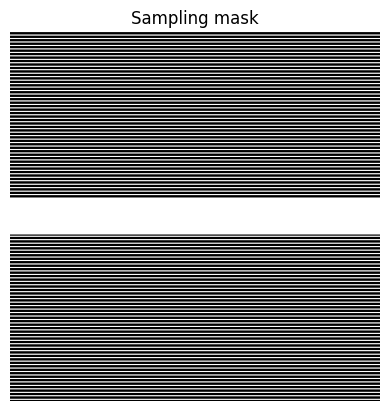

In [4]:
mask = generate_kspace_mask(image.shape, NUM_ACS_LINES, AF)
plt.imshow(mask, cmap='gray')
plt.axis("off")
plt.title("Sampling mask")

In [5]:
undersampled_kspace = kspace * mask[None]
zero_recon_image = rss(recon_ifft(undersampled_kspace))

(-0.5, 319.5, 319.5, -0.5)

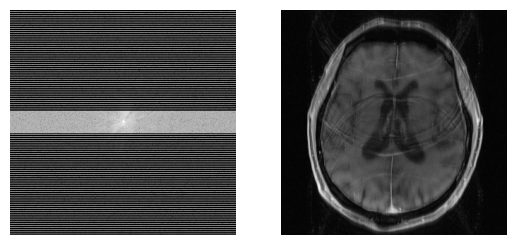

In [6]:
plt.subplot(1, 2, 1)
plt.imshow(np.log(np.abs(undersampled_kspace[0]+1e-10)), cmap='gray')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(zero_recon_image, cmap='gray')
plt.axis("off")


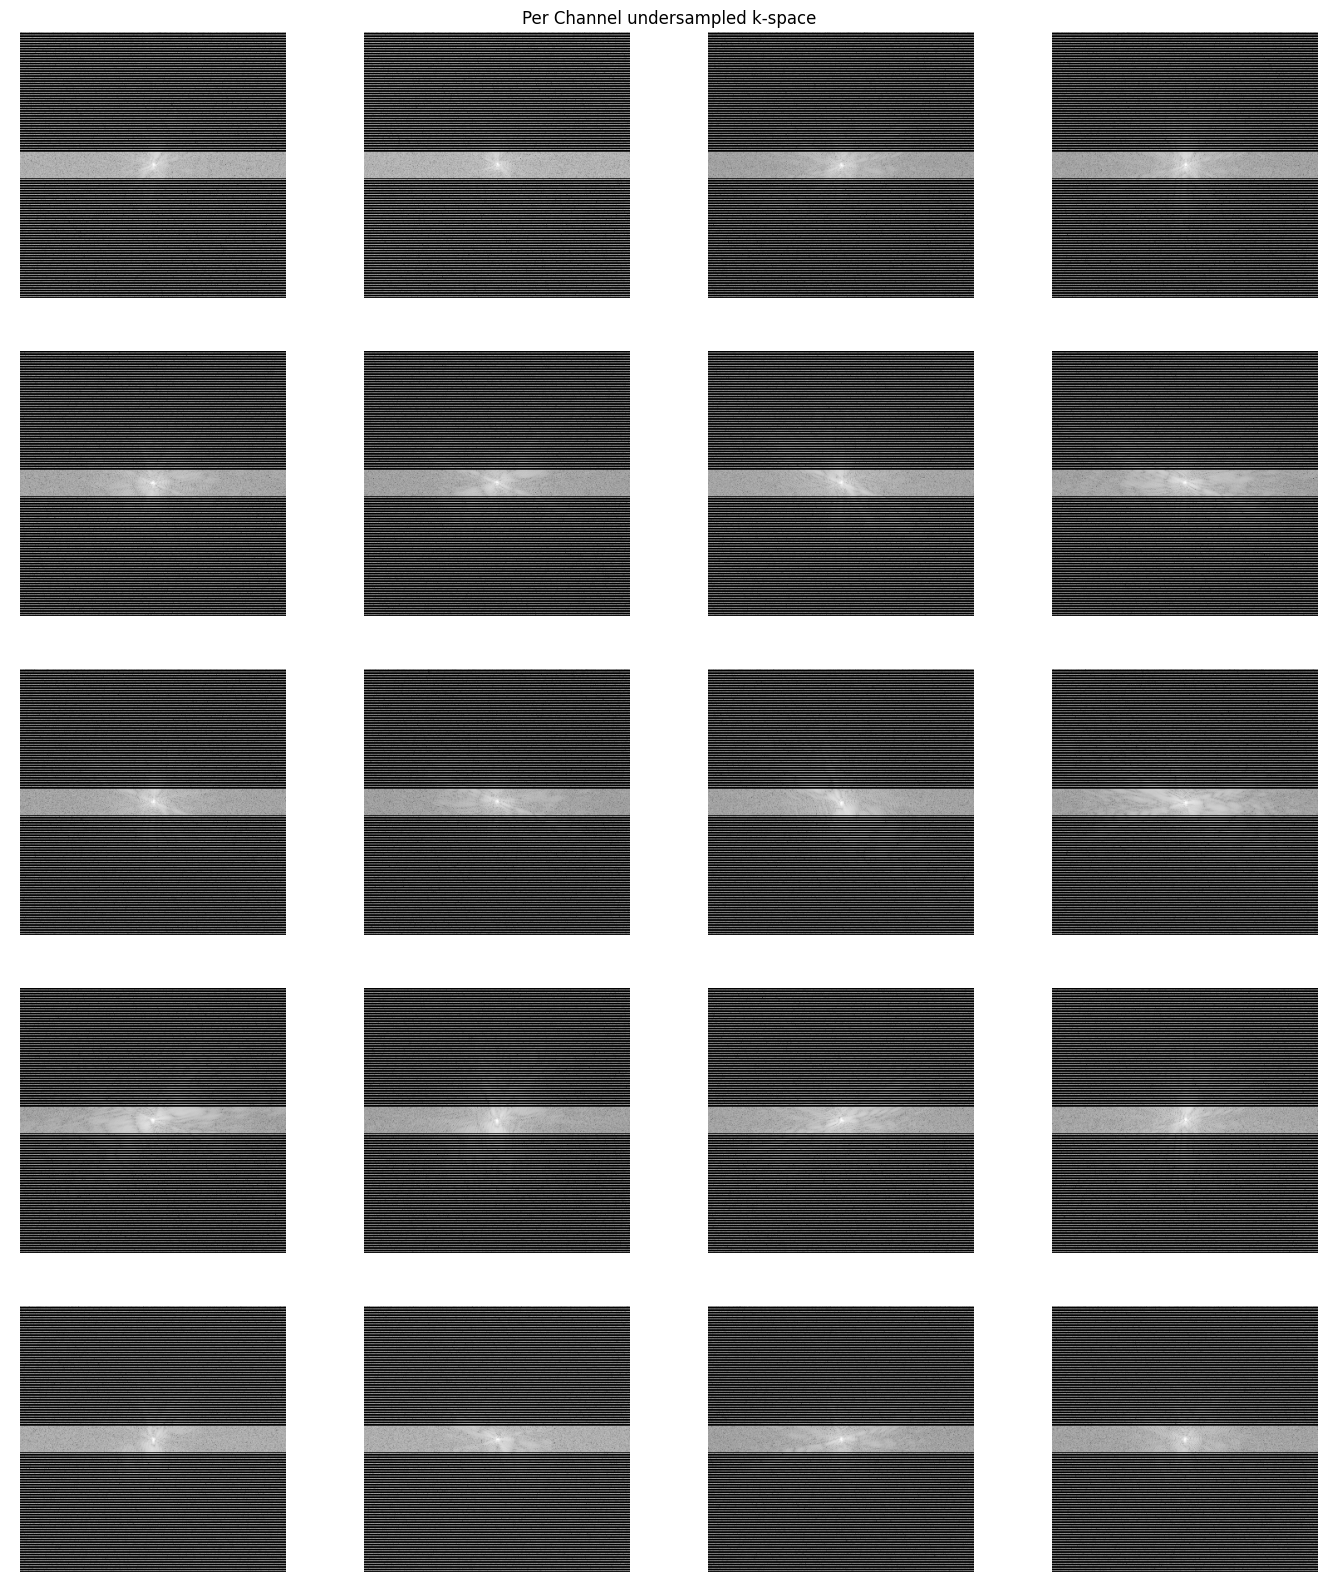

<Figure size 640x480 with 0 Axes>

In [7]:
plt.figure(figsize=(17, 20))
plt.title("Per Channel undersampled k-space")
plt.axis("off")
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.imshow(np.log(np.abs(undersampled_kspace[i]+1e-10)), cmap='gray')
    plt.axis("off")
plt.show()
plt.tight_layout()

In [8]:
autocalib = get_autocalib(undersampled_kspace, image.shape, NUM_ACS_LINES)
filled_kspace = grappa(undersampled_kspace, autocalib, kernel_size=(5, 5), coil_axis=0)

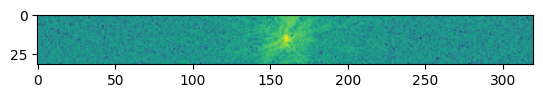

In [9]:
plt.imshow(np.log(np.abs(autocalib[0])))

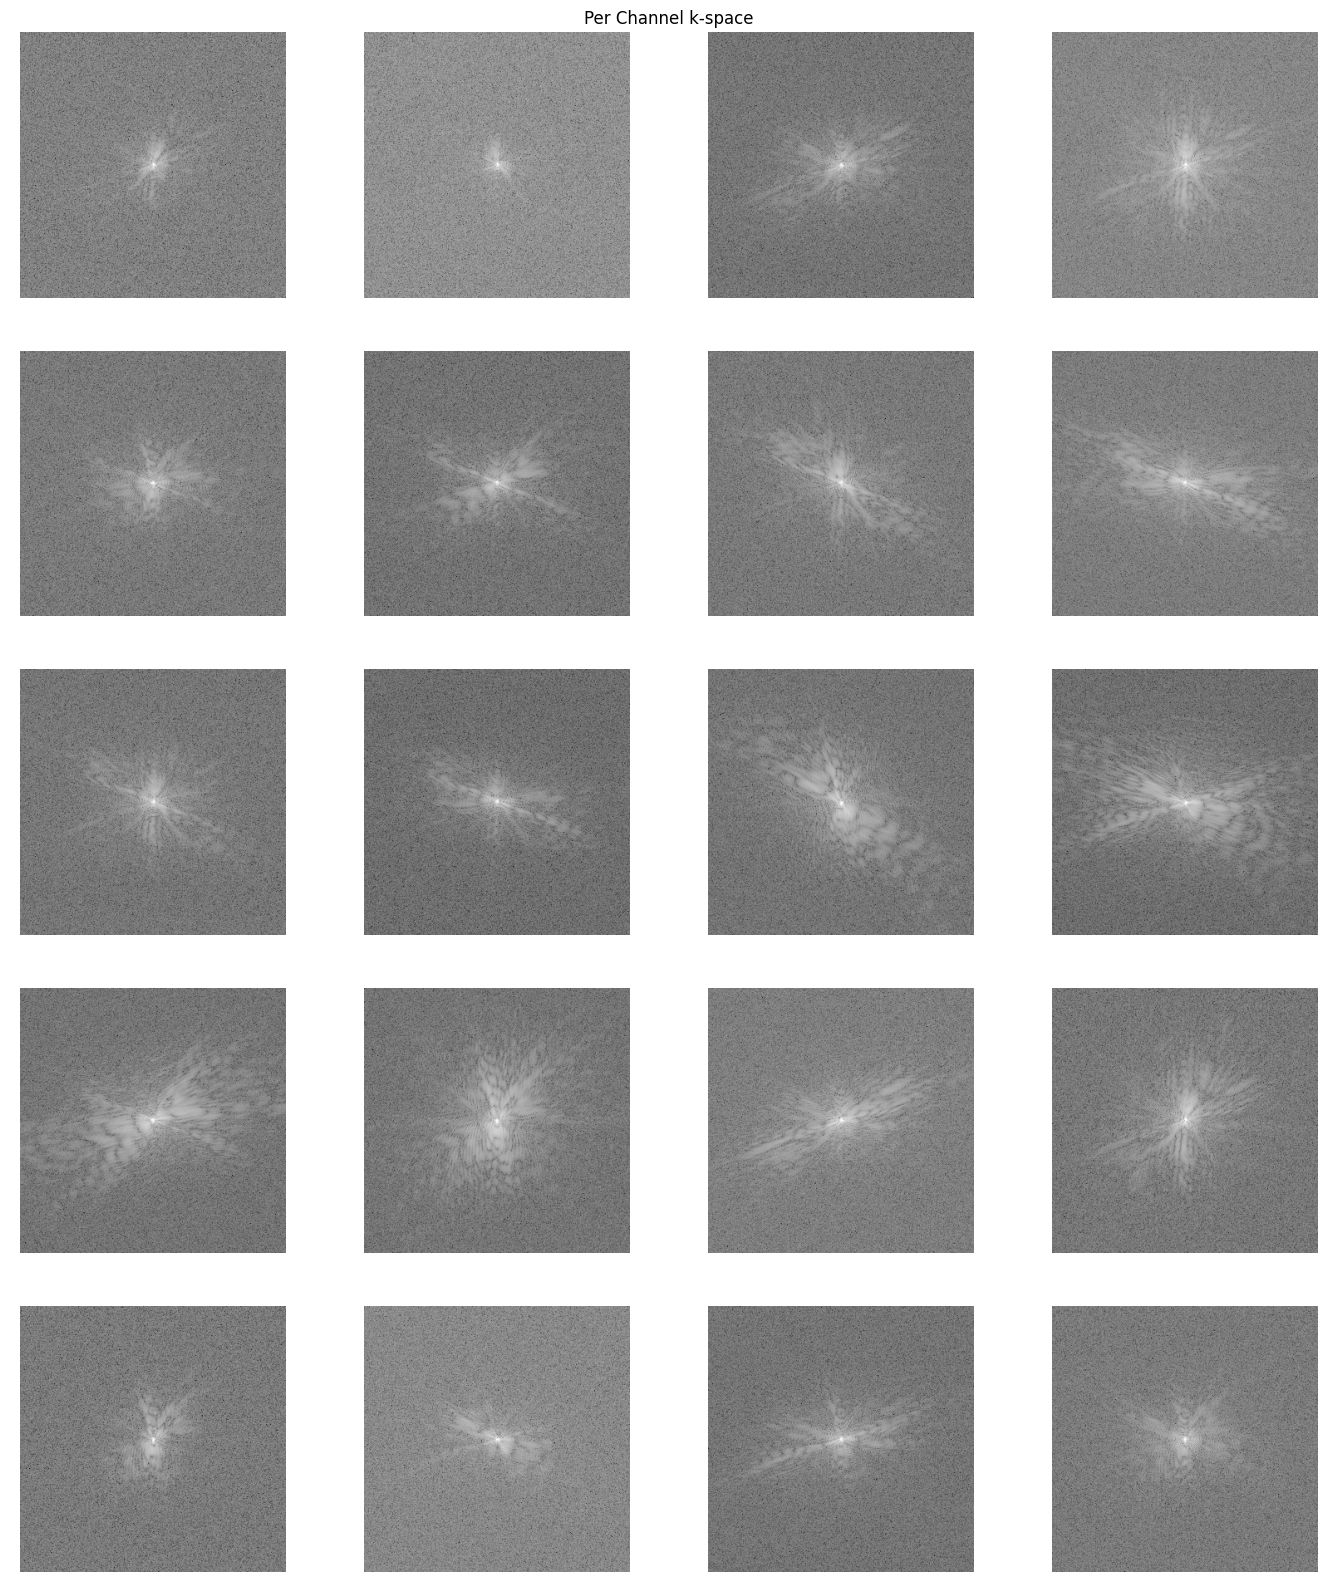

<Figure size 640x480 with 0 Axes>

In [12]:
plt.figure(figsize=(17, 20))
plt.title("Per Channel k-space")
plt.axis("off")
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.imshow(np.log(np.abs(kspace[i]+1e-10)), cmap='gray')
    plt.axis("off")
plt.show()
plt.tight_layout()

In [26]:
recons = recon_ifft(filled_kspace)

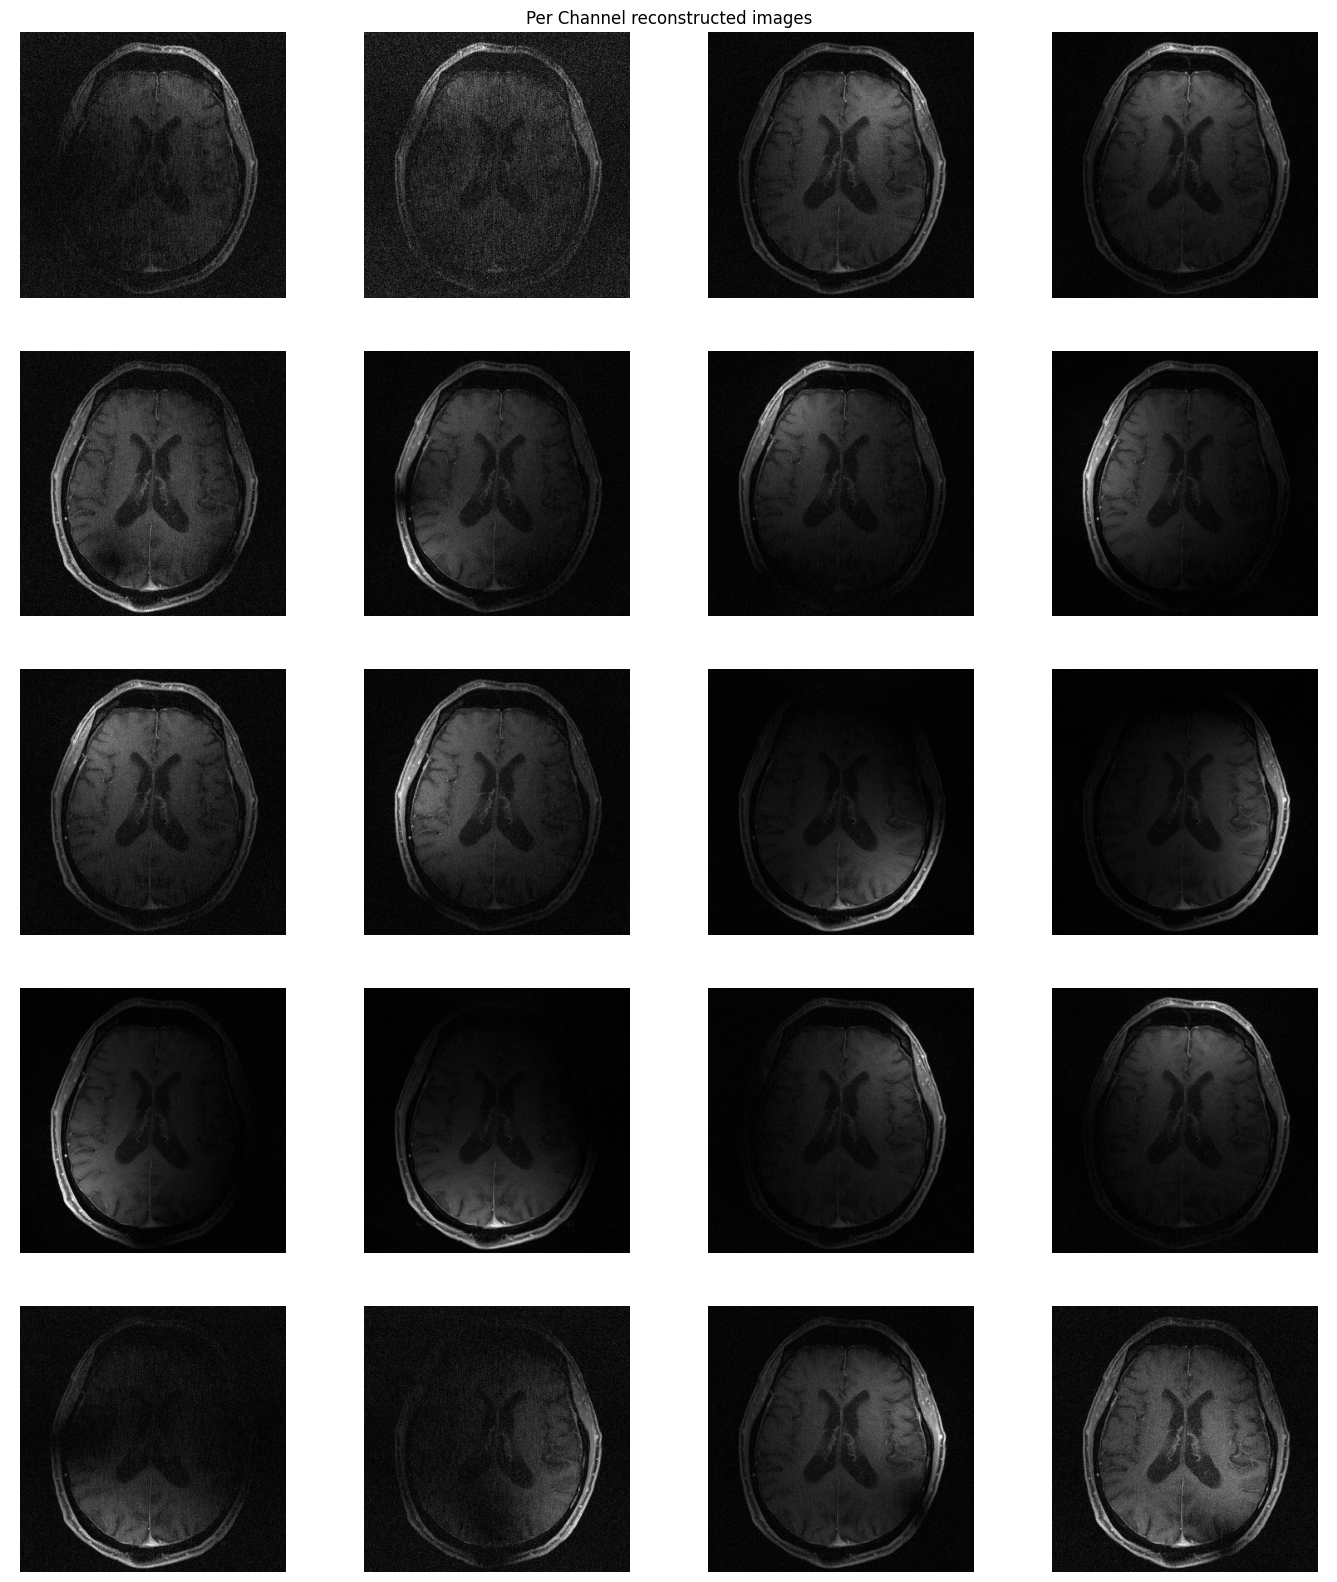

<Figure size 640x480 with 0 Axes>

In [27]:
plt.figure(figsize=(17, 20))
plt.title("Per Channel reconstructed images")
plt.axis("off")
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.imshow(np.abs(recons[i]), cmap='gray')
    plt.axis("off")
plt.show()
plt.tight_layout()

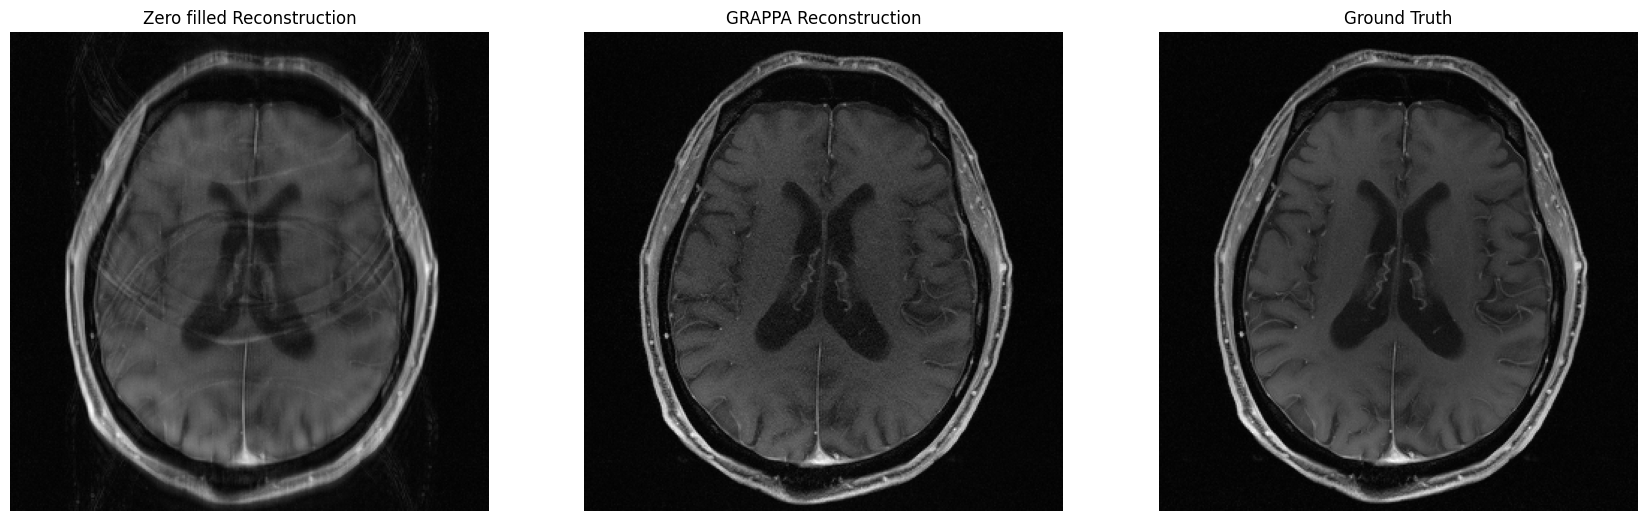

In [28]:
titles = ["Zero filled Reconstruction", "GRAPPA Reconstruction", "Ground Truth"]
plt.figure(figsize=(21, 7))
for i, I in enumerate([zero_recon_image, rss(recons), image]):
    plt.subplot(1, 3, i+1)
    plt.imshow(I, cmap='gray')
    plt.axis("off")
    plt.title(titles[i])
